In [1]:
import torch
from torch import nn
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import typing as tp
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import torchvision
import torchvision.datasets

In [4]:
means = (0.4914, 0.4822, 0.4465)
stds = (0.2023, 0.1994, 0.2010)

In [5]:
batch_size = 128

def get_data_loaders(transform):
    train_dataset = torchvision.datasets.CIFAR10(
        root = os.getcwd(), train = True, download = True,
        transform = transform
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root = os.getcwd(), train = False, download = True,
        transform = transform
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size, shuffle = True
    )

    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size, shuffle = False
    )

    return train_data_loader, test_data_loader


In [6]:
num_classes = 10

In [7]:
@torch.no_grad()
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    # model.eval()
    for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n += labels.size(0)
        tp += (predicted == labels).sum()
    return tp / n

@torch.no_grad()
def get_loss(model, data_loader, device, loss_function):
    loss = 0
    n = 0
    # model.eval()
    for images, labels in data_loader:
        labels = labels.to(device)
        images = images.to(device)
        outputs = model(images)
        loss += loss_function(outputs, labels)
        n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

In [8]:
def train(model, data_loader, test_data_loader, num_epochs, loss_function, optimizer, device):
  train_acc, test_acc = [], []
  start_time = time.time()
  for epoch in range(1, num_epochs+1):
    # model.train(True)
    start_epoch = time.time()
    accuracies = []
    losses = []
    for _, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()
    curr_train_acc = torch.stack(accuracies).mean()
    train_acc.append(curr_train_acc)
    test_acc.append(get_accuracy(model, test_data_loader, device).cpu())
    print(f"Epoch ({epoch}): Loss = {torch.stack(losses).mean():.4f}, Train accuracy = {curr_train_acc:.4f}, Time of epoch = {time.time() - start_epoch:.4f}")
  print(f'Total time {time.time() - start_time}')
  return (train_acc, test_acc)

In [9]:
def plot_history(history, model_name, num_epochs):
  train_acc, test_acc = history
  x = list(range(1, num_epochs+1))
  plt.figure(figsize=(8,5))
  plt.plot(x, train_acc, label='train')
  plt.plot(x, test_acc, label='test')
  plt.title(f'{model_name}: Accuracy by epoch')
  plt.legend()
  plt.savefig(model_name)
  plt.close()

# Модели

In [10]:
base_models = {
    "ResNet18" :
          torchvision.models.get_model('ResNet18', weights='ResNet18_Weights.IMAGENET1K_V1'),
    "GOOGLENET" :
          torchvision.models.get_model('GOOGLENET', weights='GoogLeNet_Weights.IMAGENET1K_V1'),
    "SHUFFLENET_V2_X1_0":
          torchvision.models.get_model('SHUFFLENET_V2_X1_0', weights='ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1'),
    "DENSENET121":
          torchvision.models.get_model('DENSENET121', weights='IMAGENET1K_V1')
}
transforms = {
    "ResNet18" : torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms(),
    "GOOGLENET" : torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1.transforms(),
    "SHUFFLENET_V2_X1_0": torchvision.models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1.transforms(),
    "DENSENET121": torchvision.models.DenseNet121_Weights.IMAGENET1K_V1.transforms()
}
base_models

{'ResNet18': ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [11]:
def simple_layer(in_features: int):
    return torch.nn.Linear(in_features, 10)

def hard_layer(in_features: int):
    return  torch.nn.Sequential(
                torch.nn.Linear(in_features, in_features//2),
                torch.nn.ReLU(),
                torch.nn.Linear(in_features//2, 10))

def change_last_layer(model, name: str):
    model = copy.deepcopy(model)
    if name.startswith("ResNet18") or name.startswith("GOOGLENET") or name.startswith("SHUFFLENET_V2_X1_0"):
        if name.endswith("simple"):
            model.fc = simple_layer(model.fc.in_features)
        else:
            model.fc = hard_layer(model.fc.in_features)
    elif name.startswith("DENSENET121"):
        for param in model.parameters():
            param.requires_grad = False
        if name.endswith("simple"):
            model.classifier = simple_layer(model.classifier.in_features)
        else:
            model.classifier = hard_layer(model.classifier.in_features)
    else:
        raise NameError(f"Unknown model {name}")
    return model

for name, model in base_models.items():
    change_last_layer(model=model, name=name)

In [12]:
models = {k+'_simple' : change_last_layer(model, k+'_simple') for k, model in base_models.items()}
models.update({k+'_hard': change_last_layer(model, k+'_hard') for k, model in base_models.items()})
models

{'ResNet18_simple': ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


# Обучение

In [13]:
results: dict[str, tp.Any] = {'My VGG': 0.8402}

In [14]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
for name, model in models.items():
    print("======================================")
    print(f"Training {name}...")
    model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    train_data_loader, test_data_loader = get_data_loaders(transforms[name.rsplit('_', 1)[0]])
    history = train(model, train_data_loader, test_data_loader, num_epochs, loss_function, optimizer, device)
    curr_loss = get_loss(model, test_data_loader, device, loss_function).cpu()
    curr_accuracy = get_accuracy(model, test_data_loader, device).cpu()
    print(f'Test loss = {curr_loss:.4f}, '+
          f'Test accuracy = {curr_accuracy:.4f}\n')
    results[name] = curr_accuracy
    plot_history(history, name, num_epochs)
    model.to(torch.device('cpu'))
    torch.cuda.empty_cache()

Training ResNet18_simple...
Files already downloaded and verified
Files already downloaded and verified
Epoch (1): Loss = 0.5087, Train accuracy = 0.8249, Time of epoch = 123.0052
Epoch (2): Loss = 0.2756, Train accuracy = 0.9063, Time of epoch = 121.7615
Epoch (3): Loss = 0.1872, Train accuracy = 0.9363, Time of epoch = 134.8770
Epoch (4): Loss = 0.1283, Train accuracy = 0.9550, Time of epoch = 138.4141
Epoch (5): Loss = 0.1007, Train accuracy = 0.9652, Time of epoch = 130.1561
Total time 648.2148742675781
Test loss = 0.0025, Test accuracy = 0.9057

Training GOOGLENET_simple...
Files already downloaded and verified
Files already downloaded and verified
Epoch (1): Loss = 0.4620, Train accuracy = 0.8419, Time of epoch = 153.7979
Epoch (2): Loss = 0.2576, Train accuracy = 0.9116, Time of epoch = 158.8788
Epoch (3): Loss = 0.1894, Train accuracy = 0.9354, Time of epoch = 154.7620
Epoch (4): Loss = 0.1459, Train accuracy = 0.9497, Time of epoch = 155.9365
Epoch (5): Loss = 0.1159, Train ac

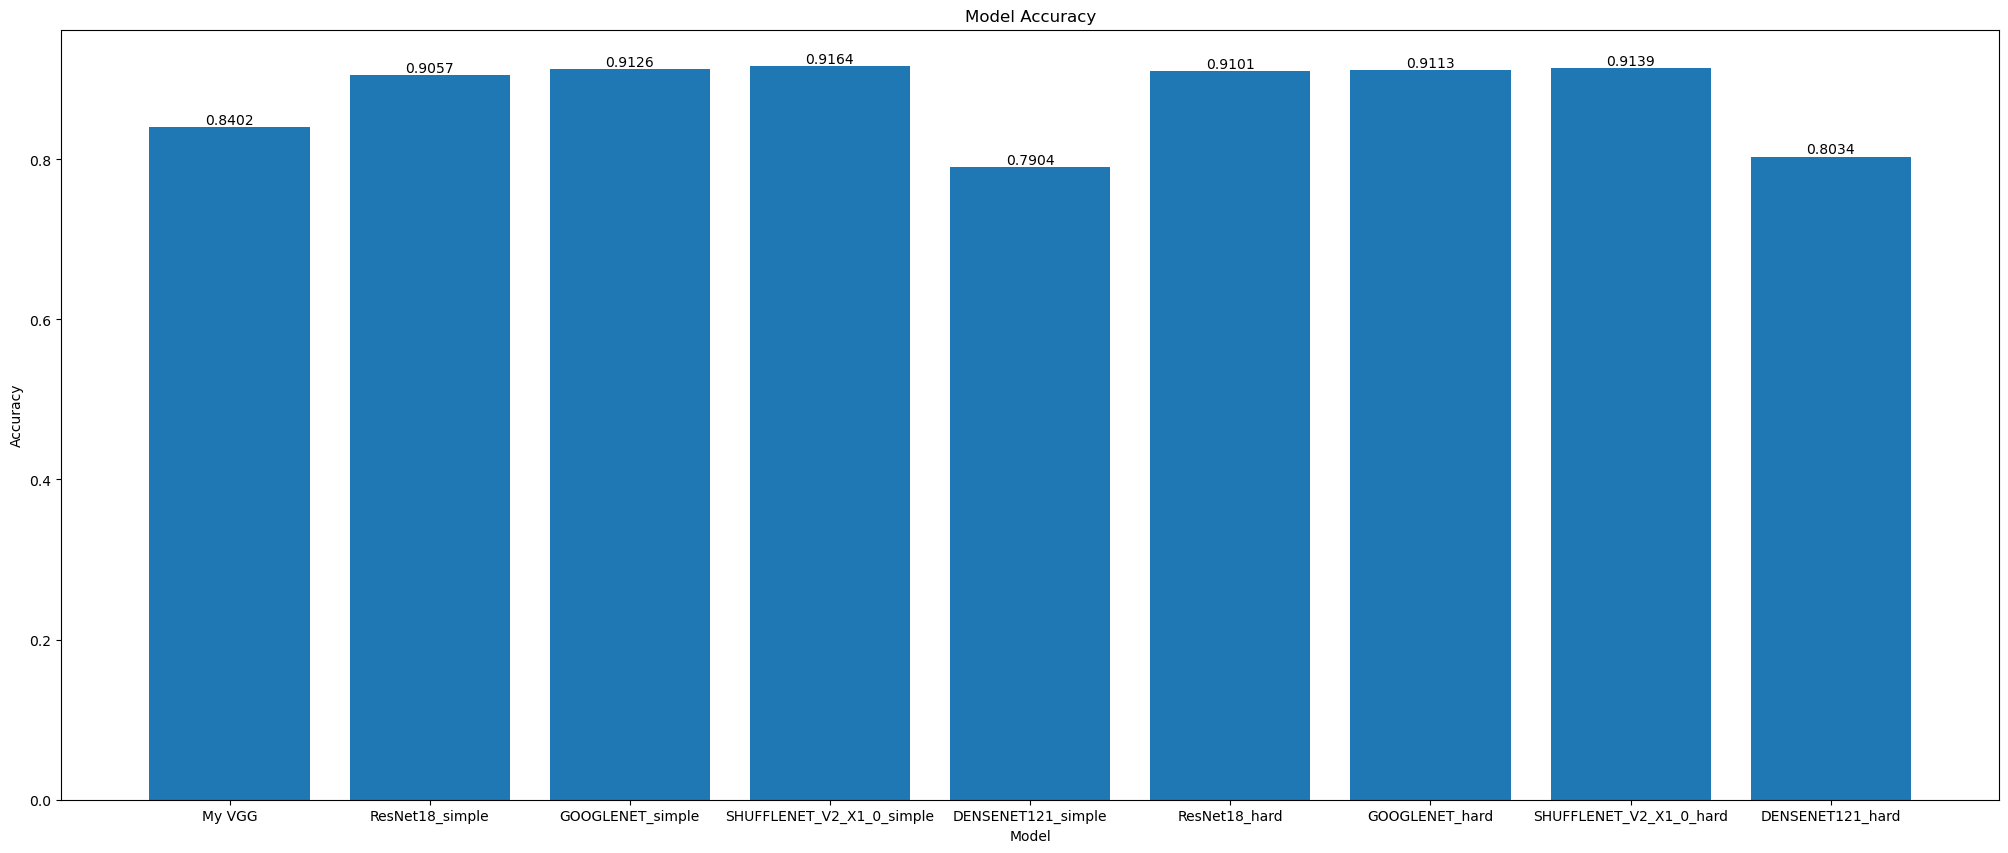

In [16]:
plt.figure(figsize=(25, 10))

plt.bar(results.keys(), results.values())
for i, val in enumerate(results.values()):
    plt.text(i, val, f"{val:.4f}", ha='center', va='bottom')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.show()
